In [1]:
import sys, os
sys.path.insert(0, "/mnt/scratch/baburish/TPN-training/TriplePandelReco_JAX")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from tensorflow_probability.substrates import jax as tfp
# Import JAX and require double precision.
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
dtype = jnp.float64

# Other tools.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Import TriplePandel stuff
from lib.simdata_i3 import I3SimHandler
from lib.geo import center_track_pos_and_time_based_on_data
from lib.gupta_network_eqx_4comp import get_network_eval_v_fn, get_network_eval_v_fn_f32
from lib.experimental_methods import get_vertex_seeds
from fitting.llh_scanner import get_scanner
from fitting.llh_fitter import get_fitter
from dom_track_eval import get_eval_network_doms_and_track
from likelihood_conv_mpe_logsumexp_gupta import get_neg_c_triple_gamma_llh

# A custom color scheme
from palettable.cubehelix import Cubehelix
cx = Cubehelix.make(start=0.3, rotation=-0.5, n=16, reverse=False, gamma=1.0,
     	max_light=1.0,max_sat=0.5, min_sat=1.4).get_mpl_colormap()

# Specify the grid.
dzen = 0.07 # rad
dazi = 0.07 # rad
n_eval = 50 # number of grid points per axes

# Assume 4-component gupta by default
n_hidden = 96
gupta = True
n_comp = 4

2025-10-03 10:53:15.066779: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
network_path = '/mnt/scratch/baburish/TPN-training/gupta_mixture_jax/test_no_penalties_tree_start_epoch_35.eqx'

In [5]:
network_path = '/mnt/scratch/baburish/TPN-training/TriplePandelReco_JAX/data/gupta/n96_4comp/new_model_no_penalties_tree_start_epoch_800.eqx'

In [3]:
try:
    ni = "f64"
    print("Running f64 model")
    eval_network_v = get_network_eval_v_fn(bpath=network_path, dtype=dtype, n_hidden=n_hidden)
except:
    ni = "f32"
    print("Running f32 model")
    eval_network_v = get_network_eval_v_fn_f32(bpath=network_path, dtype=dtype, n_hidden=n_hidden)

eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v, dtype=dtype, gupta=gupta, n_comp=n_comp)

Running f64 model


2025-10-03 10:53:18.662606: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.6 which is older than the PTX compiler version (12.9.86). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Running f32 model


In [20]:
PATH_TO_INPUT = '/mnt/research/IceCube/Gupta-Reco/22645/tfrecords/ftr/'
META_FILE_NAME = 'meta_ds_22645_from_0_to_1000_10_to_100TeV.ftr'
PULSES_FILE_NAME = 'pulses_ds_22645_from_0_to_1000_10_to_100TeV.ftr'

In [42]:
PATH_TO_INPUT = '/mnt/scratch/baburish/TPN-training/highE_data'
META_FILE_NAME = 'meta_ds_event_8_N100_from_0_to_10_1st_pulse.ftr'
PULSES_FILE_NAME = 'pulses_ds_event_8_N100_from_0_to_10_1st_pulse.ftr'


In [4]:
PATH_TO_INPUT = '/mnt/scratch/baburish/TPN-training/lowE_data'
META_FILE_NAME = 'meta_ds_event_5352_from_0_to_10_1st_pulse.ftr'
PULSES_FILE_NAME = 'pulses_ds_event_5352_from_0_to_10_1st_pulse.ftr'


In [4]:
PATH_TO_INPUT = '/mnt/scratch/baburish/TPN-training/matti'
META_FILE_NAME = 'meta_ds_21217_from_10000_to_20000_1_to_10TeV.ftr'
PULSES_FILE_NAME = 'pulses_ds_21217_from_10000_to_20000_1_to_10TeV.ftr'

In [5]:
sim_handler = I3SimHandler(
					os.path.join(PATH_TO_INPUT, META_FILE_NAME),
                    os.path.join(PATH_TO_INPUT, PULSES_FILE_NAME),
                    'data/icecube/detector_geometry.csv'
				)

In [6]:
EVENT_INDEX=0

meta, pulses = sim_handler.get_event_data(EVENT_INDEX)
print(f"muon energy: {meta['muon_energy']/1.e3:.1f} TeV")

# Get dom locations, first hit times, and total charges (for each dom).
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

# Remove early pulses.
sim_handler.replace_early_pulse(event_data, pulses)
print("n_doms", len(event_data))

# Get MCTruth.
true_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
true_time = meta['muon_time']
true_zenith = meta['muon_zenith']
true_azimuth = meta['muon_azimuth']
true_src = jnp.array([true_zenith, true_azimuth])
print("true direction:", true_src)

muon energy: 21.7 TeV
n_doms 49
true direction: [2.73088889 4.10857937]


In [7]:
SEED =  "spline_mpe"
if SEED == "spline_mpe":
    # Use SplineMPE as a seed.
    track_pos = jnp.array([meta['spline_mpe_pos_x'], meta['spline_mpe_pos_y'], meta['spline_mpe_pos_z']])
    track_time = meta['spline_mpe_time']
    track_zenith = meta['spline_mpe_zenith']
    track_azimuth = meta['spline_mpe_azimuth']
    track_src = jnp.array([track_zenith, track_azimuth])

elif SEED == "truth":
    track_pos = true_pos
    track_time = true_time
    track_zenith = true_zenith
    track_azimuth = true_azimuth
    track_src = true_src

In [8]:
print("seed direction:", np.rad2deg(track_src), "deg")
print("original seed vertex:", track_pos, "m")

center_track_seed = True

centered_track_pos, centered_track_time = track_pos, track_time
if center_track_seed:
    print("shifting seed vertex.")
    centered_track_pos, centered_track_time = center_track_pos_and_time_based_on_data(event_data, track_pos, track_time, track_src)

print("seed vertex:", centered_track_pos, "m")

fitting_event_data = jnp.array(event_data[['x', 'y', 'z', 'time', 'charge']].to_numpy())
print(fitting_event_data.shape)

seed direction: [156.7743717  230.76694839] deg
original seed vertex: [  10.47918979   98.99622507 -289.4440387 ] m
shifting seed vertex.
seed vertex: [ 83.12259525 187.96101034 -21.79666099] m
(49, 5)


In [9]:
GAUS_CONV_WIDTH = 3.0
neg_llh = get_neg_c_triple_gamma_llh(eval_network_doms_and_track, sigma=GAUS_CONV_WIDTH)

In [10]:
use_multiple_vertex_seeds = True
prescan_time = True
fit_llh = get_fitter(
                        neg_llh,
                        use_multiple_vertex_seeds=use_multiple_vertex_seeds,
                        prescan_time=prescan_time
                    )

# JIT! We want it to be fast.
fit_llh_jit = jax.jit(fit_llh)

# Run the fit
solution = fit_llh_jit(track_src, centered_track_pos, centered_track_time, fitting_event_data)
best_logl, best_direction, best_vertex, best_time= solution

print("")
print("solution found.")
print(f"logl: {best_logl:.3f}")
print(f"direction: {np.rad2deg(best_direction)} deg")
print("")


solution found.
logl: 803.070
direction: [156.55967624 232.68462498] deg



In [11]:
N_SPLITS = 50

scan_llh = get_scanner(
                        neg_llh,
                        use_multiple_vertex_seeds=use_multiple_vertex_seeds,
                        prescan_time=prescan_time,
                        n_splits=N_SPLITS,
                        use_jit=True
                    )

zenith = jnp.linspace(true_src[0]-dzen, true_src[0]+dazi, n_eval)
azimuth = jnp.linspace(true_src[1]-dzen, true_src[1]+dazi, n_eval)
X, Y = jnp.meshgrid(zenith, azimuth)

print("running the scan.")

running the scan.


In [12]:
solution = scan_llh(X, Y, best_vertex, best_time, fitting_event_data)
# use below if you want to use original seed values (not best-fit values)
# as seed for vertex minimization during scan.
# solution = scan_llh(X, Y, centered_track_pos, centered_track_time, fitting_event_data)

sol_logl, sol_vertex, sol_time = solution
logls = sol_logl.reshape(X.shape)

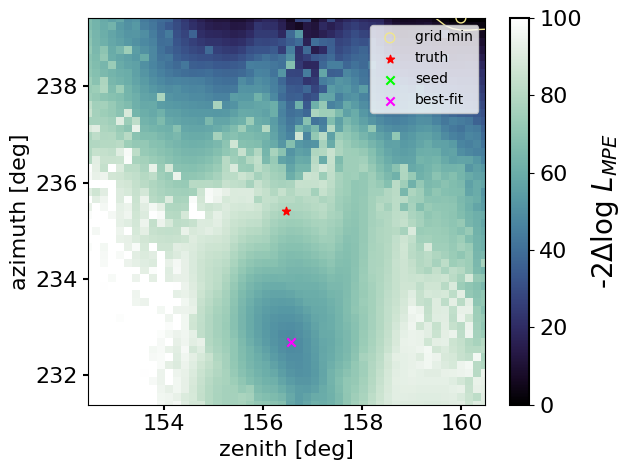

: 

In [13]:
# Plot.
fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([100, 1.2*np.amax(delta_logl)]), shading='auto', cmap=cx)
# pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, shading='auto', cmap=cx)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{MPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

contours = [4.61]
ix1, ix2 = np.where(delta_logl==0)
ax.scatter(np.rad2deg([X[ix1, ix2]]), np.rad2deg([Y[ix1, ix2]]), s=50, marker='o', facecolors='none', edgecolors='khaki', zorder=100., label='grid min')
ct = plt.contour(np.rad2deg(X), np.rad2deg(Y), delta_logl, levels=contours, linestyles=['solid'], colors=['khaki'], linewidths=1.0)

ax.scatter(np.rad2deg(true_src[0]), np.rad2deg(true_src[1]), marker="*", color='red', label="truth", zorder=200)
ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="x", color='lime', label="seed", zorder=200)
ax.scatter(np.rad2deg(best_direction[0]), np.rad2deg(best_direction[1]), marker="x", color="magenta", label="best-fit", zorder=200)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([true_src[0]-dzen, true_src[0]+dzen]))
ax.set_ylim(np.rad2deg([true_src[1]-dazi, true_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

plt.legend()
plt.tight_layout()
# plt.savefig(f"f32_scan_ev_{EVENT_INDEX}.png", dpi=300)
# plt.savefig(f"{ni}_scan_ev_{EVENT_INDEX}.png", dpi=300)
plt.show()